In [2]:
import sys
sys.path.append('../../Polished_code')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tools import *

In [4]:
import scipy.io
# tx_elevation = scipy.io.loadmat('../../Simulation/dataset/ld_tx_ele.mat')['ld_tx_ele']
# rx_elevation = scipy.io.loadmat('../../Simulation/dataset/ld_tx_ele.mat')['ld_rx_ele']
tx_ele = scipy.io.loadmat('../../Simulation/dataset/data_with_building/ele_tx.mat')['ele_matrix']
rx_ele = scipy.io.loadmat('../../Simulation/dataset/data_with_building/ele_rx.mat')['ele_rx_set']

In [316]:
np.mean(tx_ele), np.mean(rx_ele)

(39.82689090418573, 68.21130484294146)

In [319]:
np.max(tx_ele)

154.7016308726743

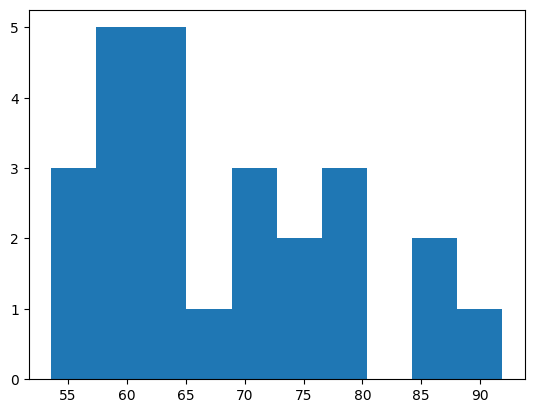

In [323]:
_ = plt.hist(rx_ele.flatten())

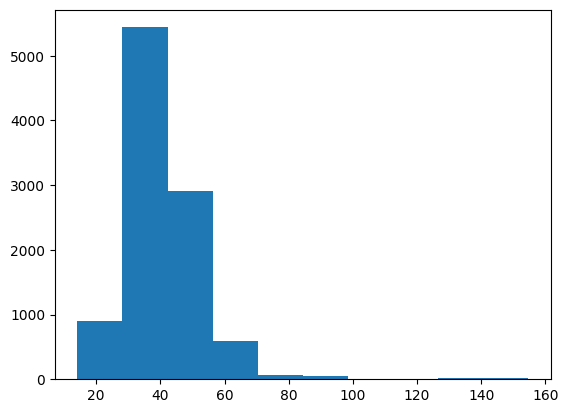

In [321]:
_ = plt.hist(tx_ele.flatten())

<Axes: >

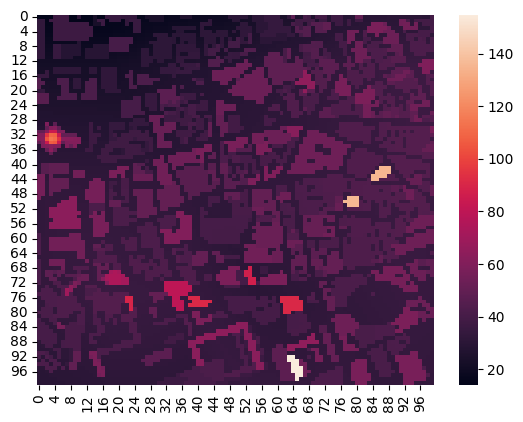

In [318]:
sns.heatmap(tx_ele)

In [59]:
tx_ele_array = tx_ele.flatten()
rx_ele_array = rx_ele.flatten()

In [8]:
tx_rx_diff = np.repeat(tx_ele_array[:, None], len(rx_ele_array), axis=-1) - rx_ele_array

In [5]:
location = 'london_square_20'
base = f'../../Simulation/dataset/data_with_building/{location}_cell.mat'

meta = scipy.io.loadmat(base)['london_square_20_cell'][0][0]
cir_profile_ld = meta[0]
TX_ld = meta[1].T
RX_ld = meta[2].T
distance_tr = meta[3]
n_tx, n_rx = len(TX_ld), len(RX_ld)
r_tx, r_rx = int(np.sqrt(n_tx)), int(np.sqrt(n_rx))

In [ ]:
location = 'london_square_20'
base = f'../../Simulation/dataset/data_with_building/{location}_cell.mat'
# base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

In [40]:
cir_profile_ld[7889, 23][0,1]

(8.195934830195528e-07+0j)

In [61]:
def extract_features(cirs):
        '''
        Extracting manual defined features:
            mean excess delay tau_m
            max excess delay tau_max
            rms delay spread tau_rms
            total received power P
            number of multipath components N
            power of first path P_1
            arrival time of first path tau_1
        '''
        features = []
        T, S = cirs.shape

        for j in range(T):
            cir_t = [] # channel impulse response for a transmitter
            for i in range(S):
                c_tmp = cirs[j, i]
                
                m, n = c_tmp.shape
                if m < 2:
                    tau_m, tau_max, tau_rms, P, N, P_1, tau_1 = 0, 0, 0, 0, 0, 0, 0
                else:
                    tau_m = np.real(c_tmp[0]).mean()
                    tau_max = np.real(c_tmp)[0, -1]
                    P = np.linalg.norm(c_tmp[1])
                    P_1 = np.linalg.norm(c_tmp[1, 0])
                    tau_1 = np.real(c_tmp[0, 0])
                    N = n

                features.append(np.array([tau_m, tau_max, tau_1, P, P_1, N]))

        return np.reshape(np.array(features), (T, -1))

In [422]:
cirs_feature = extract_features(cir_profile_ld)

In [7]:
BBox = ((-0.1005, -0.0804, 51.5091, 51.5184))

london_map = plt.imread('./map_1.png')

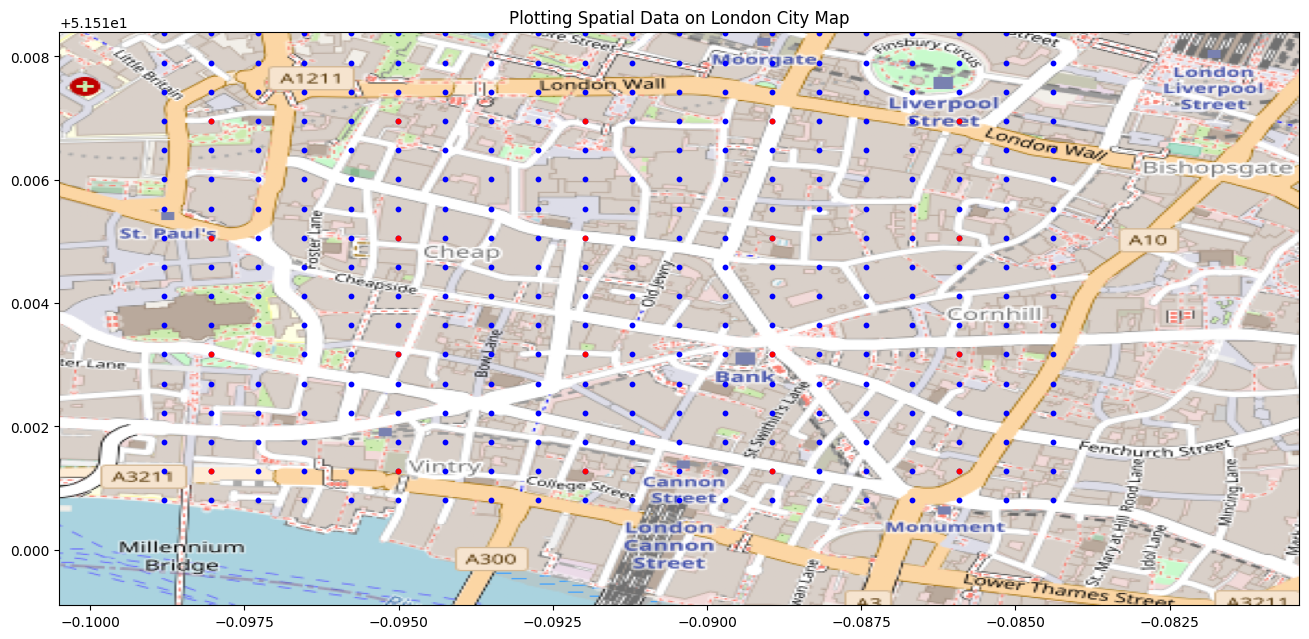

In [13]:
fig, ax = plt.subplots(figsize = (16,16))
ax.scatter(TX_ld[:, 1], TX_ld[:, 0], zorder=1, c='b', s=10)
ax.scatter(RX_ld[:, 1], RX_ld[:, 0], zorder=1, c='r', s=10)
ax.set_title('Plotting Spatial Data on London City Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(london_map, zorder=0, extent=BBox, aspect= 'equal')

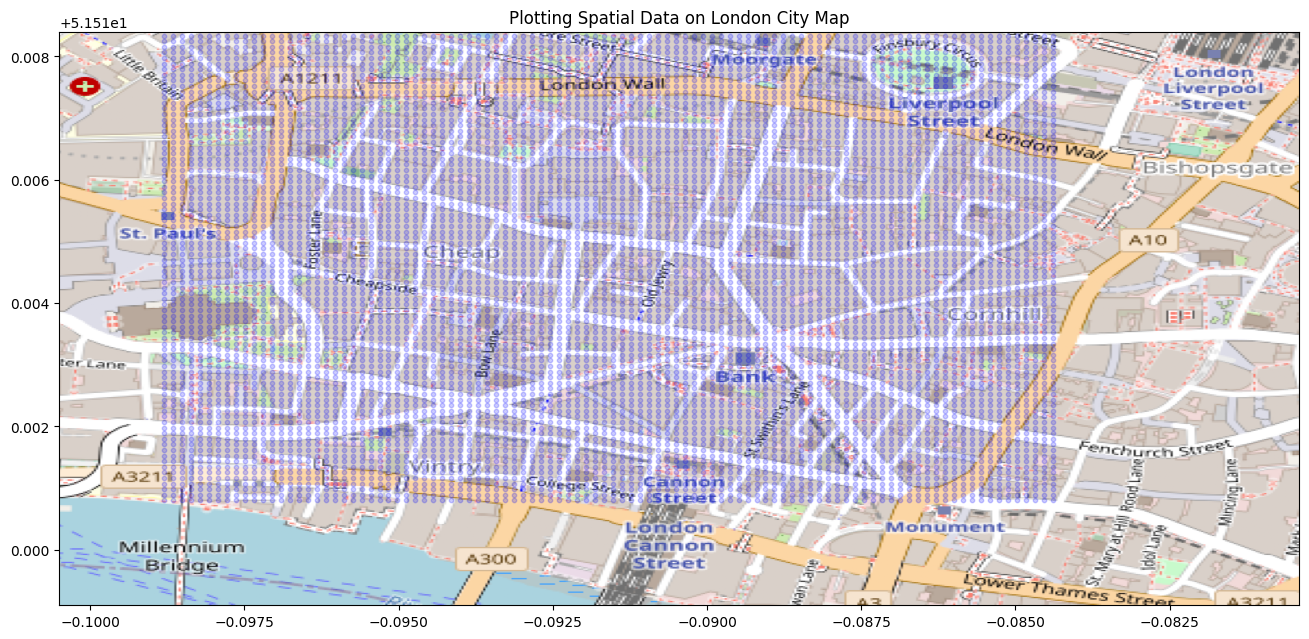

In [114]:
fig, ax = plt.subplots(figsize = (16,16))
ax.scatter(TX_ld[:, 1], TX_ld[:, 0], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on London City Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(london_map, zorder=0, extent=BBox, aspect= 'equal')

## num_reflections

In [12]:
num_impulse_ls = []

for cirs in cir_profile_ld:
    for cir in cirs:
        num_impulse_ls.append(cir.shape[1])

In [13]:
num_reflections = np.reshape(num_impulse_ls, cir_profile_ld.shape)

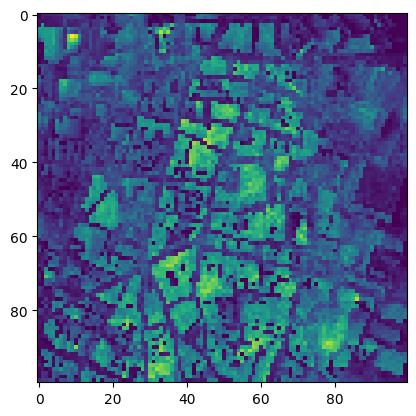

In [14]:
heatmap_reflects = num_reflections.sum(axis=1)
plt.imshow(heatmap_reflects.reshape(r_tx, -1))

Text(0.5, 1.0, 'Distribution of num_reflections on each base station')

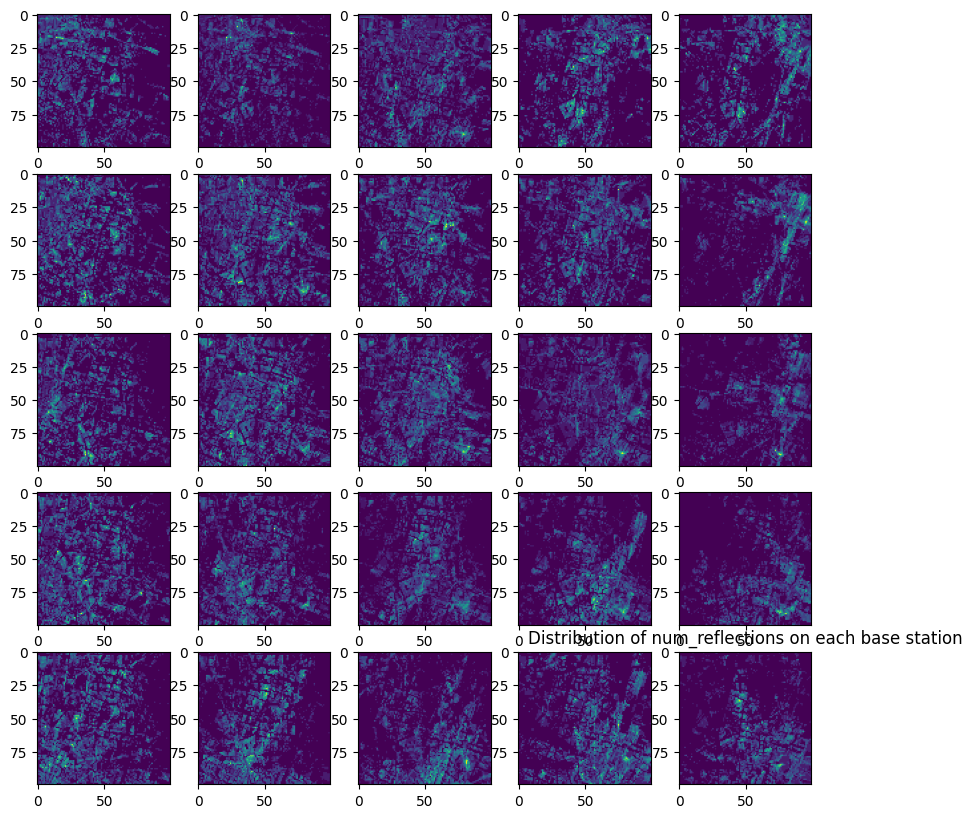

In [15]:
_, axs = plt.subplots(r_rx, r_rx, figsize=(10, 10))
axs = axs.flatten()
for i in range(n_rx):
    ele_array = num_reflections[:, i]
    ele_map = np.reshape(ele_array, (r_tx, r_tx))
    axs[i].imshow(ele_map)

plt.title('Distribution of num_reflections on each base station')

## CFR | PSD

In [272]:
import scipy.signal

In [64]:
# data preparation for observations

# initiate an extractor
ext_ld = Extractor(cir_profile_ld)
# formatting CIR profiles
X_ld = ext_ld.formatting_X(max_len=20)

../../Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
../../Polished_code\tools.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float').flatten())


In [65]:
fc = 2e6 # sampling rate
W = 1e6 # cut-off freq
t_max = max(ext_ld.delay_set)
t = np.linspace(0, t_max, int(fc * t_max)+1)

C:\Users\11740\AppData\Local\Temp\ipykernel_960\3966915807.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  t = np.linspace(0, t_max, int(fc * t_max)+1)


In [276]:
cirs_obs, cirs_pure = sinc_filter(cir_profile_ld, t, W)

In [277]:
cirs_obs = np.array(cirs_obs)
cirs_pure = np.array(cirs_pure)

In [21]:
seq_len = len(t)
cfr = None
for i in range(0, cirs_obs.shape[1], seq_len):
    tmp = np.fft.fft(cirs_obs[:, i:i+seq_len])
    if cfr is not None:
        cfr = np.concatenate([cfr, tmp], axis=1)
    else:
        cfr = tmp

In [22]:
cfr_test = np.fft.fft(cirs_obs)

In [278]:
cirs_norm = np.linalg.norm(cirs_obs, axis=1).reshape(r_tx, r_tx, n_rx)
cfrs_norm = np.linalg.norm(cfr, axis=1).reshape(r_tx, r_tx, n_rx)

<Axes: >

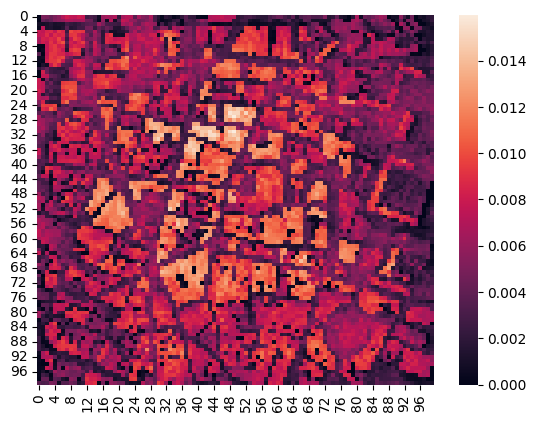

In [604]:
sns.heatmap(cfrs_norm.sum(axis=-1))

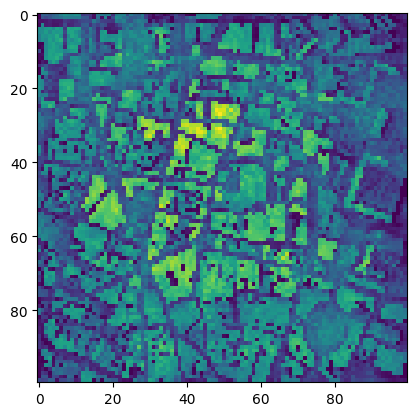

In [24]:
plt.imshow(cirs_norm.sum(axis=-1))
plt.imshow(cfrs_norm.sum(axis=-1))

Text(0.5, 1.0, 'Distribution of CIR norms on each base station')

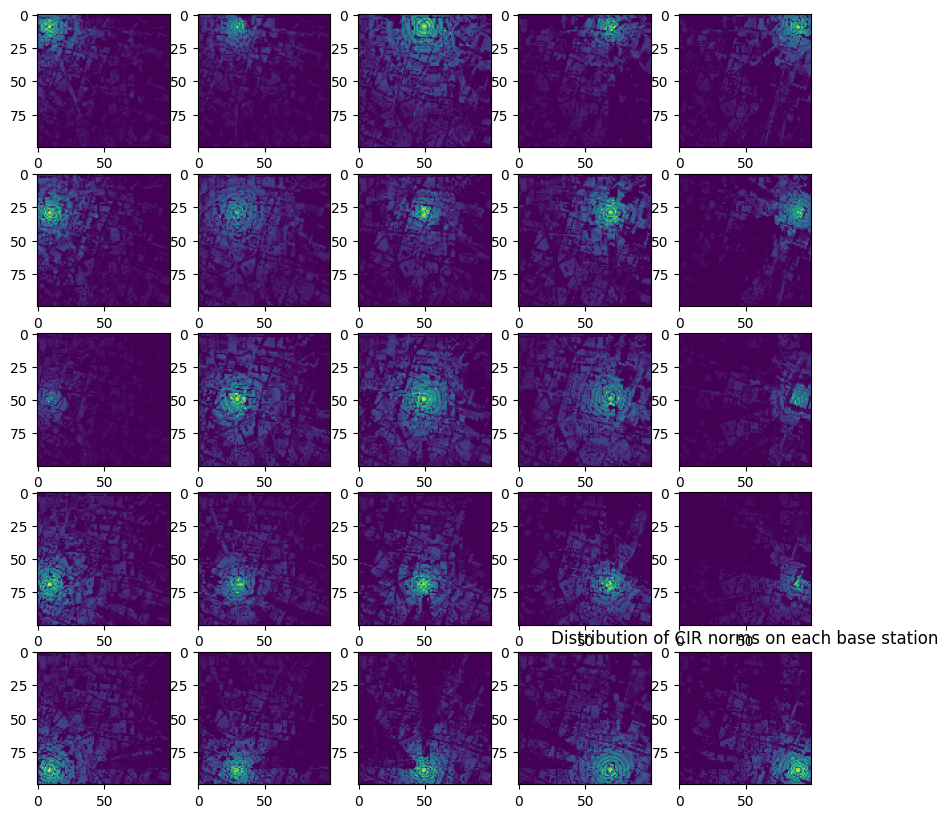

In [25]:
_, axs = plt.subplots(r_rx, r_rx, figsize=(10, 10))
axs = axs.flatten()
for i in range(n_rx):
    cir_intensity = cirs_norm[:, :, i]
    axs[i].imshow(cir_intensity)

plt.title('Distribution of CIR norms on each base station')

In [279]:
cfr_complex = np.concatenate([np.real(cfr), np.imag(cfr)], axis=1)

In [83]:
np.save('./data/cfr', cfr_complex)

In [280]:
cirs_norm_flatten = cirs_norm.reshape(n_tx, -1)

In [358]:
cirs_norm_train, cirs_norm_test, tx_train, tx_test, dist_train, dist_test = train_test_split(cirs_norm_flatten, TX_ld, distance_tr)

In [70]:
distance_tr.flatten()

array([146.0912872 , 313.90428167, 522.18848834, ..., 521.79750017,
       336.59939678, 163.00350604])

In [350]:
cirs_feature_train, cirs_feature_test, tx_train, tx_test = train_test_split(np.real(cirs_feature), TX_ld)

In [356]:
import pandas as pd

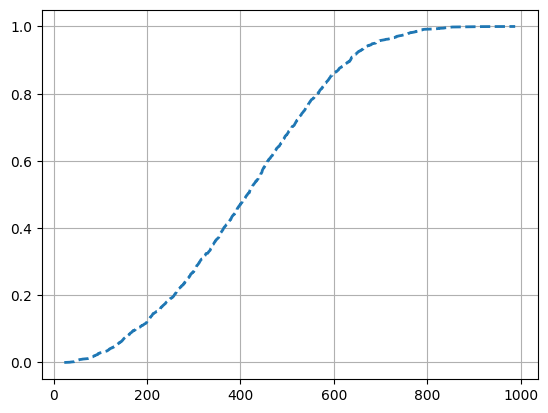

In [351]:
pipe = test_pipe(cirs_norm_train, cirs_norm_test, tx_train, tx_test)
plt.grid()

In [284]:
lgb_pipe.fit(cirs_norm_train, tx_train)

Pipeline(steps=[('lgb',
                 MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=1,
                                                              max_depth=50,
                                                              n_estimators=800,
                                                              reg_lambda=0,
                                                              subsample=1)))])

In [285]:
dist_pred = lgb_pipe.predict(cirs_norm_test)

In [290]:
np.shape(cirs_norm_flatten)

(10000, 25)

In [291]:
dist_error = dist_from_geo(dist_pred, tx_test)


In [293]:
idxs = dist_error.argsort()[:1000]
idxs_worst = dist_error.argsort()[-1000:]

In [273]:
y_pred = optimal_search(RX_ld, dist_test)

In [253]:
sim_mat = np.dot(dist_test, dist_pred.T) / np.linalg.norm(dist_test) / np.linalg.norm(dist_pred)

In [ ]:
y_pred_2 = optimal_search(RX_ld, dist_test)

In [ ]:
cdf_plot(dist_from_geo(y_pred, tx_test))

## Learn with tx-rx distance
- Ensemble method trained offline: distance as output prediction
- Searching for optimal point matching the distance prediction

In [352]:
def dist_from_cat(cart1, cart2):
    """
    returns an array of distance from cart1 and cart2
    cart1: an array of cartisen coordinates
    cart2: an array of cartisen coordinates
    """
    return np.array([np.linalg.norm(i-j) for i, j in zip(cart1, cart2)])

def test_pipe(x_train, x_test, y_train, y_test, ax=plt, coord='geo'):
    '''function training model and outputs cdf plot'''
    lgb_pipe = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])
    lgb_pipe.fit(x_train, y_train)
    y_pred = lgb_pipe.predict(x_test)   

    if coord == 'geo':
        dist_error = dist_from_geo(y_pred, y_test)
    else:
        dist_error = dist_from_cat(y_pred, y_test)
    
    cdf_plot(dist_error, ax=ax)

    return lgb_pipe

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [45]:
lgb_pipe = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])

In [46]:
from sklearn.metrics import make_scorer

In [101]:
def preprocess_cir(cirs, num=400):
    '''Preprocess CIR
    reshape to shape (num_tx, dim_fingerprints)
    Turn complex CIR to real fingperprint database: [Real, Image]
    '''
    cirs = np.reshape(cirs, (num, -1))
    r, i = np.real(cirs), np.imag(cirs)
    return np.concatenate([r, i], axis=1)

In [464]:
cirs_obs = preprocess_cir(cirs_obs, num=n_tx)
cirs_pure = preprocess_cir(cirs_pure, num=n_tx)

In [469]:
pure_train, pure_test, obs_train, obs_test, tx_train, tx_test = train_test_split(cirs_pure, cirs_obs, TX_ld)

In [ ]:
pure_train, pure_test, obs_train, obs_test, dist_train ,dist_test, tx_train, tx_test = train_test_split(cirs_pure, cirs_obs, distance_tr, TX_ld)

### Learn with building elevations

In [416]:
def geo2cart(RX):
    '''
    Transfer geolocation to cartesian coordinates
    take 1st rx as origin, other coordinations are positions relative to the origin
    '''
    cart_grids = [np.array([0, 0])]

    for i in range(1, len(RX)):
        lat_tmp = geodesic([RX[i][0], RX[0][1]], RX[0]).m
        lon_tmp = geodesic([RX[0][0], RX[i][1]], RX[0]).m

        cart_grids.append(np.array([lat_tmp, lon_tmp]))

    return np.array(cart_grids)

def cart2geo(cart, corner):
    ''''
    Transfer cartesian coordination to geolocation 
    '''
    lat = geodesic(cart[0] / 1000).destination(corner, 0).latitude
    lon = geodesic(cart[1] / 1000).destination(corner, 90).longitude
    return np.array([lat, lon])

In [417]:
TX_ld_cart = geo2cart(TX_ld)

In [349]:
cirs_with_elevation = np.concatenate([cirs_norm_flatten, tx_ele_array[:, None]], axis=1)

In [418]:
pure_train, pure_test, elevation_train, elevation_test, norm_train, norm_test, tx_train, tx_test = train_test_split(cirs_pure, cirs_with_elevation, cirs_norm_flatten, TX_ld_cart)

In [338]:
lgb_pipe_2 = copy.deepcopy(lgb_pipe)

In [ ]:
test_pipe(pure_train, pure_test, tx_train, tx_test, coord='cart')

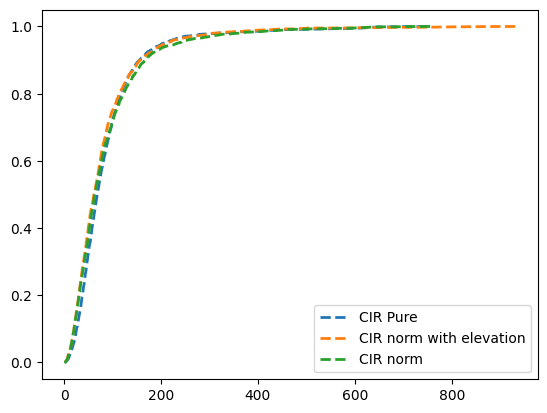

In [429]:
test_pipe(pure_train, pure_test, tx_train, tx_test, coord='cart')
test_pipe(elevation_train, elevation_test, tx_train, tx_test, coord='cart')
test_pipe(norm_train, norm_test, tx_train, tx_test, coord='cart')
plt.legend(['CIR Pure', 'CIR norm with elevation', 'CIR norm'])

## Only distance prediction

In [372]:
y_dist = distance_tr.flatten()

In [373]:
dist_3d_ls = []
for t in range(n_tx):
    for r in range(n_rx):
        dist_3d_tmp = np.sqrt(distance_tr[t, r] ** 2 + rx_ele.flatten()[r] ** 2)
        dist_3d_ls.append(dist_3d_tmp)

In [374]:
dist_3d = np.array(dist_3d_ls)

In [375]:
x_feature = np.reshape(cirs_feature, (len(y_dist), -1))

In [261]:
x_dist = np.reshape(cirs_obs, (len(y_dist), -1))


In [407]:
# np.stack((x_feature, dist_3d[:, None]))
x_feature.T.shape, dist_3d[:, None].T.shape

((6, 250000), (1, 250000))

In [415]:
f  = np.hstack((x_feature, dist_3d[:, None]))

In [448]:
cov_mtx = np.cov(f.T)

In [447]:
cov = preprocessing.normalize(np.triu(cov_mtx))

In [452]:
tmp = copy.deepcopy(cov_mtx[-1, :-1])
tmp -= tmp.min()
tmp /= tmp.max()

In [455]:
cov_mtx[-1, :-1], tmp

(array([ 2.79596152e-05, -9.31240718e-07,  4.82381706e-05, -8.10144140e-03,
        -7.31740497e-03, -1.49219009e+02]),
 array([0.99999986, 0.99999967, 1.        , 0.99994538, 0.99995064,
        0.        ]))

<Axes: >

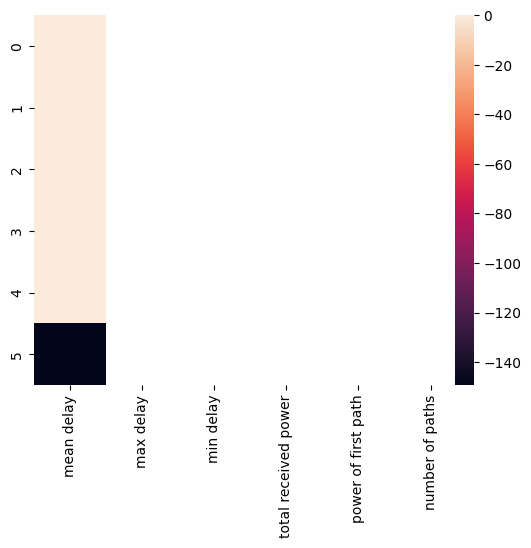

In [459]:
sns.heatmap(cov_mtx[-1, :-1][:, None], xticklabels=['mean delay', 'max delay', 'min delay', 'total received power', 'power of first path', 'number of paths'])

<Axes: >

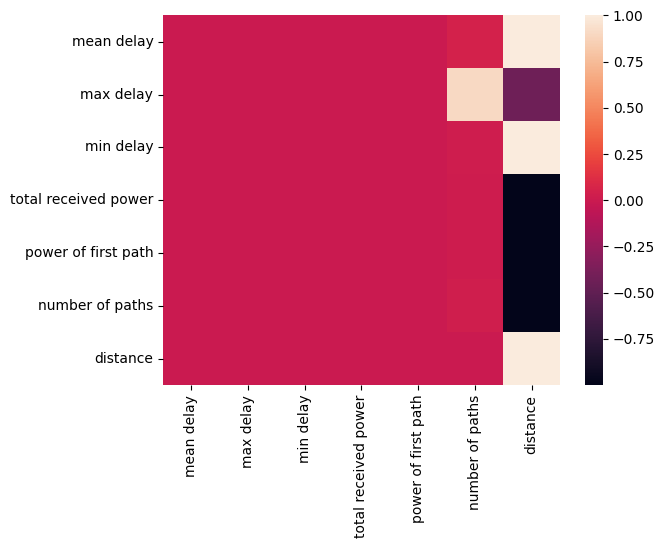

In [438]:
sns.heatmap(cov, xticklabels=['mean delay', 'max delay', 'min delay', 'total received power', 'power of first path', 'number of paths', 'distance'], yticklabels=['mean delay', 'max delay', 'min delay', 'total received power', 'power of first path', 'number of paths', 'distance'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_dist, TX_ld)

In [344]:
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x_dist, y_dist, np.arange(len(x_dist)))

In [345]:
lgb_dist = Pipeline([('lgb', lgb.LGBMRegressor(subsample=1, 
                                                        colsample_bytree=1, 
                                                        reg_lambda=0,
                                                        n_estimators=500,
                                                        max_depth=500))])

In [346]:
lgb_dist.fit(x_train, y_train)
y_pred = lgb_dist.predict(x_test)

Text(0.5, 0, 'Distance m')

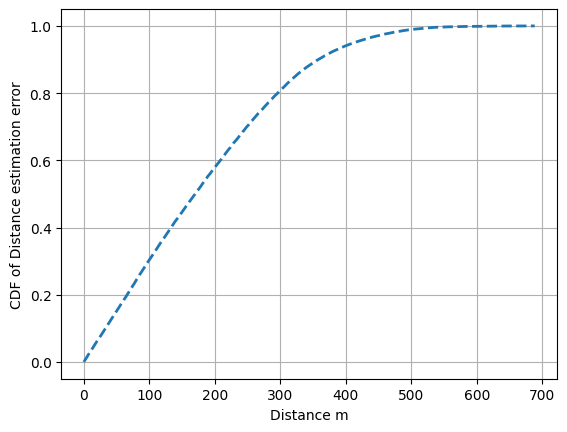

In [347]:
cdf_plot(np.abs(y_pred-y_test))
plt.grid()
plt.ylabel('CDF of Distance estimation error')
plt.xlabel('Distance m')

In [267]:
idxs = np.abs((y_pred-y_test)).argsort()[:1000]
idxs_worst = np.abs((y_pred-y_test)).argsort()[-1000:]

In [348]:
np.abs(y_pred-y_test).mean()

185.38151292456047

In [343]:
np.abs(y_pred-y_test).mean()

182.2627017255981

In [243]:
np.abs((y_pred-y_test))

array([158.12008391,   0.83161379,   1.70591533, ..., 173.15846504,
       337.8548336 ,  13.3945804 ])

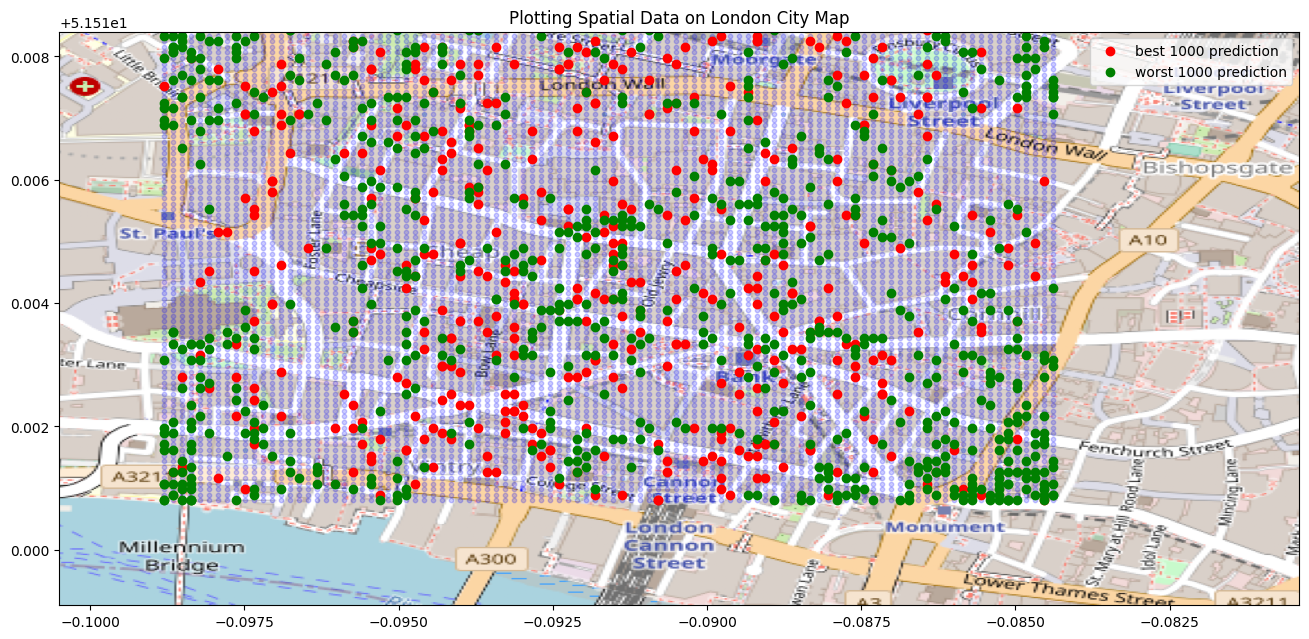

In [268]:
fig, ax = plt.subplots(figsize = (16,16))
ax.scatter(TX_ld[:, 1], TX_ld[:, 0], zorder=1, alpha= 0.2, c='b', s=10)
ax.scatter(RX_ld[:, 1], RX_ld[:, 0], zorder=1, alpha= 0.2, marker='*', s=10)
# ax.scatter(tx_test[:, 1], tx_test[:, 0], c='r')

ax.scatter(TX_ld[idx_test[idxs]//25, 1], tx_test[idx_test[idxs]//25, 0], c='r', label='best 1000 prediction')
ax.scatter(TX_ld[idx_test[idxs_worst]//25, 1], TX_ld[idx_test[idxs_worst]//25, 0], c='g', label='worst 1000 prediction')
ax.set_title('Plotting Spatial Data on London City Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(london_map, zorder=0, extent=BBox, aspect= 'equal')
ax.legend()

## kNN

In [545]:
feature_train, feature_test, obs_train, obs_test, tx_train, tx_test = train_test_split(cirs_feature, cirs_obs, TX_ld)

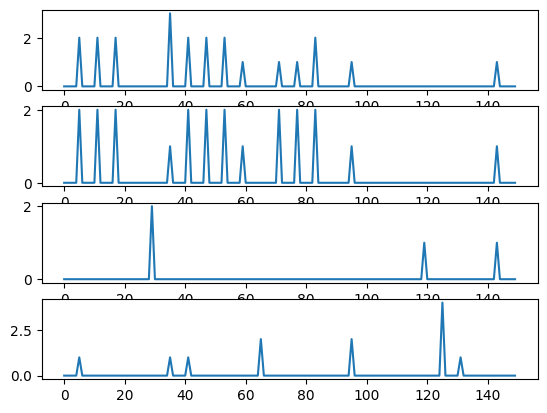

In [552]:
fig, axs = plt.subplots(4, 1)
axs[0].plot(cirs_feature[1])
axs[1].plot(cirs_feature[2])
axs[2].plot(cirs_feature[999])
axs[3].plot(cirs_feature[1000])


In [473]:
from sklearn.neighbors import NearestNeighbors, KDTree

In [569]:
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(feature_train)

In [570]:
dist, incs = nn.kneighbors(feature_test)

In [572]:
preds = np.median(np.squeeze(tx_train[incs]), axis=1)
dists = dist_from_geo(tx_test, preds)

In [600]:
num_points = 100
# neg_points = np.argpartition(dists, num_points)[:num_points]
neg_points = np.argsort(dists)[-100:]
pos_points = np.argsort(dists)[:100]

In [594]:
len(dists)

2500

In [577]:
np.median(dists), np.mean(dists)

(72.83340867360494, 146.29744734561453)

Text(0.5, 1.0, 'k-NN with CIR features, median 72m, mean 146m')

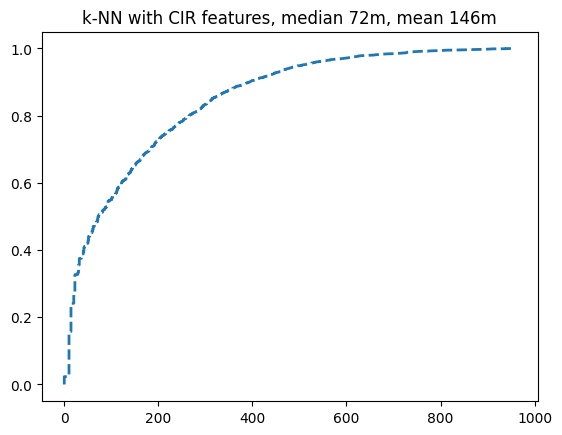

In [578]:
cdf_plot(dists)
plt.title('k-NN with CIR features, median 72m, mean 146m')

In [582]:
neg_points.shape

(100,)

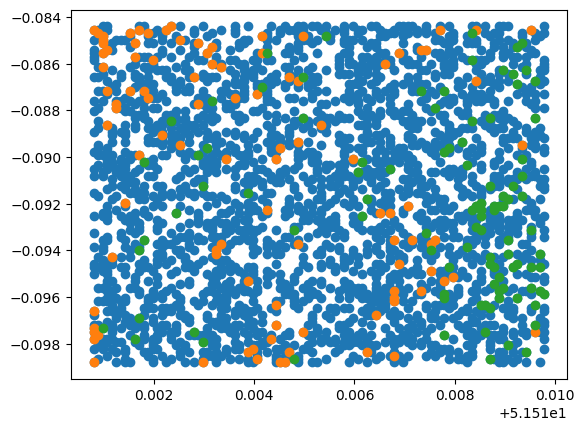

In [601]:
plot_agent(tx_test)
# plot_agent(np.squeeze(preds))
plot_agent(tx_test[neg_points])
# plot_agent(tx_train)
plot_agent(tx_test[pos_points])


In [475]:
kdt = KDTree(pure_train, leaf_size=30, metric='euclidean')

In [483]:
res = kdt.query(pure_test, k=5)

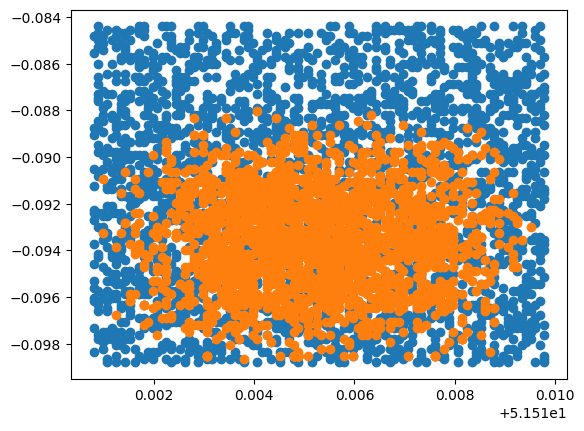

In [501]:
plot_agent(tx_test)
plot_agent(preds)
# plot_agent(tx_train)

In [523]:
TX_ld[res[-1]][4].mean(axis=0)

array([51.5157026 , -0.09437689])

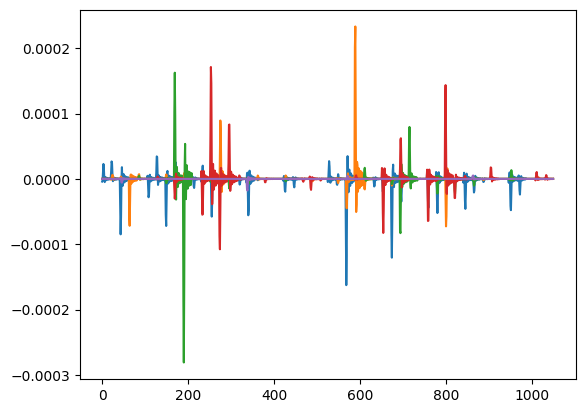

In [530]:
plt.plot(cirs_pure[res[-1][0]].T)

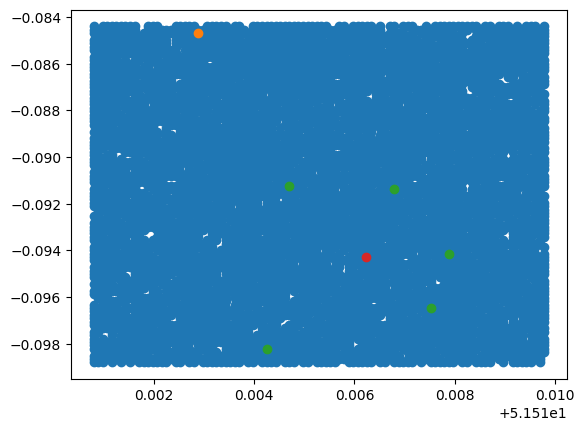

In [525]:
plot_agent(tx_train)
plot_agent(tx_test[0])
plot_agent(TX_ld[res[-1]][0])
plot_agent(TX_ld[res[-1]][0].mean(axis=0))

In [511]:
np.shape(res)
TX_ld[res[-1]].shape

(2500, 5, 2)

In [500]:
pred = np.median(TX_ld[res[-1]], axis=1)

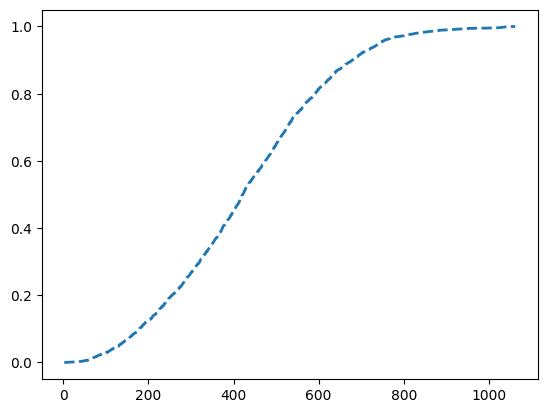

In [496]:
cdf_plot(dist_from_geo(pred, tx_test))

In [29]:
# lgb_pipe.fit(obs_train, dist_train)
lgb_pipe.fit(cirs_obs, tx_rx_distance)

Pipeline(steps=[('lgb',
                 MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=1,
                                                              max_depth=50,
                                                              n_estimators=800,
                                                              reg_lambda=0,
                                                              subsample=1)))])

In [30]:
dist_pred = lgb_pipe.predict(cirs_pure)

In [259]:
dist_pred[0]

array([842.7765877 , 673.91679672, 538.20963336, 486.98756317,
       592.20161934, 702.699757  , 609.35203758, 371.19965806,
       390.26785936, 405.0693604 , 690.17164778, 541.7046929 ,
       376.58061368, 221.11075408, 325.71230519, 618.01762745,
       457.98705067, 323.28983786, 255.50819996, 265.00537806,
       589.57987524, 551.38860858, 468.74108031, 449.33593974,
       507.69400467])

In [268]:
np.argpartition(dist_pred[0], 4)[:4]

array([13, 18, 19, 17], dtype=int64)

In [263]:
dist_pred[0]

array([842.7765877 , 673.91679672, 538.20963336, 486.98756317,
       592.20161934, 702.699757  , 609.35203758, 371.19965806,
       390.26785936, 405.0693604 , 690.17164778, 541.7046929 ,
       376.58061368, 221.11075408, 325.71230519, 618.01762745,
       457.98705067, 323.28983786, 255.50819996, 265.00537806,
       589.57987524, 551.38860858, 468.74108031, 449.33593974,
       507.69400467])

In [271]:
from scipy.optimize import minimize, Bounds

def optimal_search(RX, dist_pred, num_points=4):
    """find x through distance and rx coordinates"""

    def dist2coord(x, coords, dists):

        d = np.array([geodesic(x, coord).m for coord in coords])

        return np.linalg.norm([d-dists])**2

    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for p in dist_pred:
        idx = np.argpartition(p, num_points)[:num_points]
        RX_selected = RX_ld[idx]
        p_selected = p[idx]
        res = minimize(
        dist2coord,
        RX_selected[0],
        args=(RX_selected, p_selected),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

In [32]:
tx_pred = optimal_search(RX_ld, dist_pred)

In [39]:
tx_pred = optimal_search(RX_ld, tx_rx_distance)

In [34]:
dist = dist_from_geo(tx_pred, TX_ld)

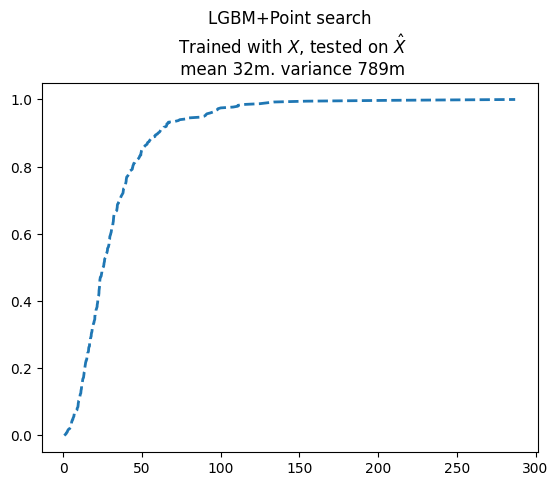

In [47]:
cdf_plot(dist)
plt.title('LGBM+Point search\n Trained with $X$, tested on $\hat{X}$\n mean 32m. variance 789m')
plt.savefig('./imgs/cir_lgbm_ps.pdf')

# Comparison: CIR peaks and CIR all profiles

In [269]:
import copy

In [270]:
lgb_pipe = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])

lgb_pipe_peak = copy.deepcopy(lgb_pipe)

In [271]:
lgb_pipe_pure = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])

In [234]:
seq_len = 27
cirs_peaks = []
ts_peaks = []

for i in range(0, cirs_obs.shape[1], seq_len):
    tmp = cirs_pure[:, i:i+seq_len]
    cirs_peaks.append(np.max(tmp, axis=1))
    ts_peaks.append(np.argmax(tmp, axis=1))

cirs_peaks = np.transpose(cirs_peaks)
ts_peaks = np.transpose(ts_peaks)

In [178]:
peak_train, peak_test, tx_train_peak, tx_test_peak = train_test_split(cirs_peaks, TX_ld)

In [228]:
pure_train, pure_test, \
    obs_train, obs_test, \
        peak_train, peak_test, \
            dist_train ,dist_test, \
                tx_train, tx_test = train_test_split(cirs_pure, \
                                                            cirs_obs, \
                                                            cirs_peaks, \
                                                            tx_rx_distance, \
                                                            TX_ld)

In [70]:
# _ = lgb_pipe_peak.fit(peak_train, tx_train)
_ = lgb_pipe.fit(obs_train, tx_train)
_ = lgb_pipe_pure.fit(pure_train, tx_train)

In [71]:
# y_pred_peak = lgb_pipe_peak.predict(peak_test)
y_pred = lgb_pipe.predict(obs_test)
y_pure = lgb_pipe_pure.predict(pure_test)

In [72]:
# error_peak = dist_from_geo(y_pred_peak, tx_test_peak)
error = dist_from_geo(y_pred, tx_test)
error_pure = dist_from_geo(y_pure, tx_test)

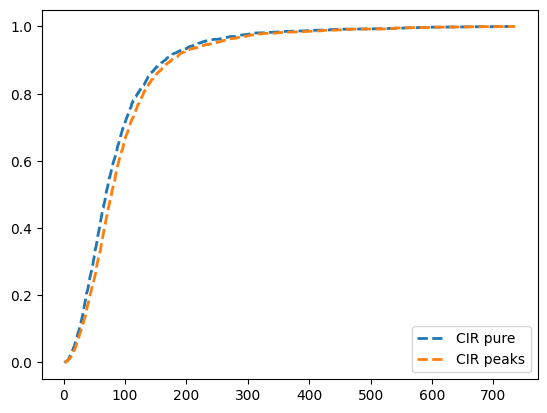

In [73]:
cdf_plot(error_pure)
# cdf_plot(error_peak)
cdf_plot(error)

plt.legend(['CIR pure', 'CIR peaks', 'CIR noisy'])

In [195]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

In [204]:
def customLoss(y_pred, y_true):
    distances = dist_from_geo(y_pred, y_true)
    # indices = xArray.index.values
    # tempArray = [1 if value1 != value2 else 0 for value1, value2 in zip(xArray.values, yTrainCV[[indices]])]
    
    return 1 #sum(distances)

scorer = {'main': 'accuracy',
          'custom': make_scorer(customLoss, greater_is_better=False)}

In [ ]:
k_folds = KFold(n_splits = 5)
cross_validate(lgb_pipe, cirs_obs, TX_ld, cv=k_folds, scoring=scorer)

## Visualize error points

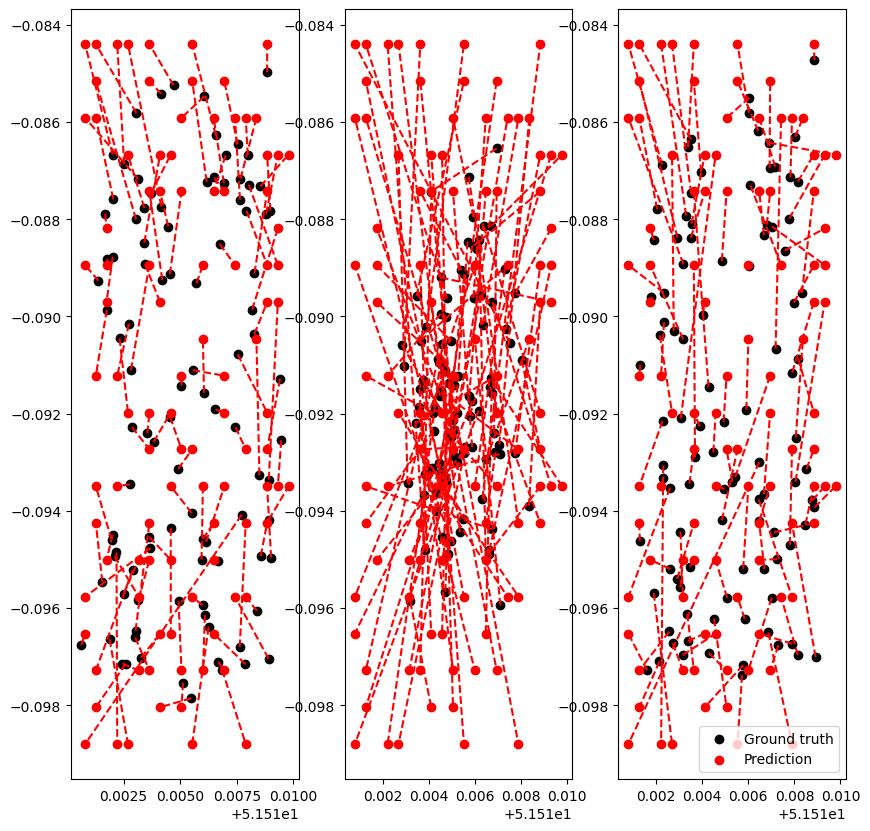

In [187]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

compare_pred(y_pure, tx_test, axs[0])
compare_pred(y_pred, tx_test, axs[2])
compare_pred(y_pred_peak, tx_test, axs[1])
plt.legend()

# Extract feature manually
- Features: number of reflections, time of primary arrival, major amplitude

In [207]:
num_reflections.shape

(400, 25)

In [236]:
feature_man = np.concatenate([num_reflections, ts_peaks, cirs_peaks], axis=1)

In [239]:
lgb_pipe_feature = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])

In [238]:
feature_train, feature_test, a_train, a_test = train_test_split(feature_man, TX_ld)

In [240]:
lgb_pipe_feature.fit(feature_train, a_train)

Pipeline(steps=[('lgb',
                 MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=1,
                                                              max_depth=50,
                                                              n_estimators=800,
                                                              reg_lambda=0,
                                                              subsample=1)))])

In [241]:
y_pred_feature = lgb_pipe_feature.predict(feature_test)

In [242]:
error_feature = dist_from_geo(y_pred_feature, a_test)

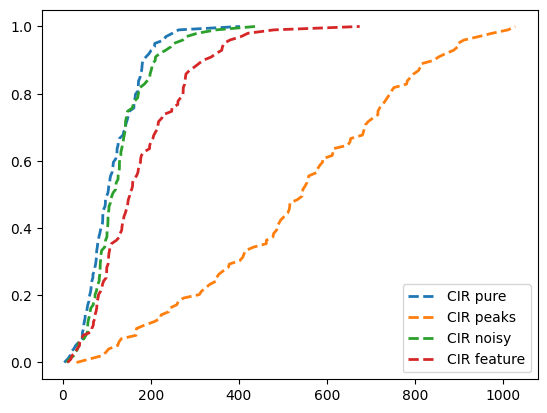

In [246]:
cdf_plot(error_pure)
cdf_plot(error_peak)
cdf_plot(error)
cdf_plot(error_feature)

plt.legend(['CIR pure', 'CIR peaks', 'CIR noisy', 'CIR feature'])

### RSSI

In [289]:
rssi_dir = f'../../Simulation/dataset/rssi_london.mat'
rssi_ld = scipy.io.loadmat(rssi_dir)['rssi_london']

rssi_ld = np.nan_to_num(rssi_ld, neginf=1) # replace nan value to 1

In [291]:
lgb_pipe_rssi = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=200,
                                                                    max_depth=20)))])

In [292]:
rssi_train, rssi_test, tx_train_rssi, tx_test_rssi = train_test_split(rssi_ld, TX_ld)

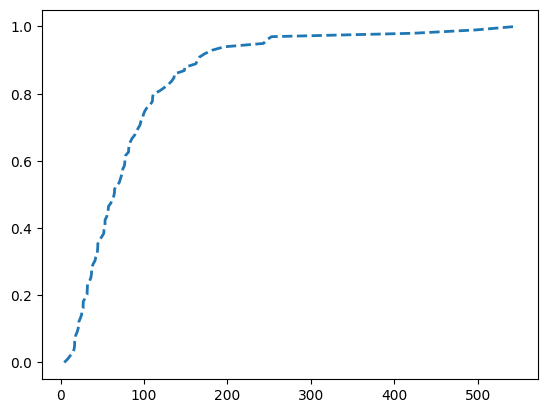

In [294]:
lgb_pipe_rssi.fit(rssi_train, tx_train_rssi)

y_pred_rssi = lgb_pipe_rssi.predict(rssi_test)
error_rssi = dist_from_geo(y_pred_rssi, tx_test_rssi)
cdf_plot(error_rssi)

### CSI fingerprints
- Channel frequence response, amplitude and phase

In [432]:
from sklearn import preprocessing

In [251]:
cfr_real, cfr_imag = np.real(cfr), np.imag(cfr)

In [257]:
amplitude = cfr_real**2 + cfr_imag**2
amplitude_nmlz = preprocessing.normalize(amplitude)

In [266]:
phase = np.arctan(cfr_imag / cfr_real)

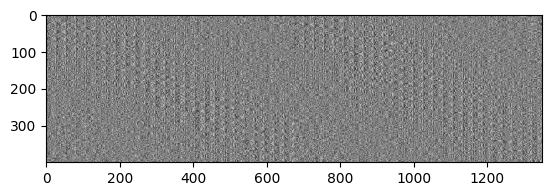

In [267]:
plt.imshow(preprocessing.normalize(phase), 'gray')

In [281]:
lgb_pipe_phase = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=1000,
                                                                    max_depth=20)))])

In [282]:
phase_train, phase_test, tx_train_phase, tx_test_phase = train_test_split(np.concatenate([phase, amplitude_nmlz], axis=1), TX_ld)

In [283]:
lgb_pipe_phase.fit(phase_train, tx_train_phase)

Pipeline(steps=[('lgb',
                 MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=1,
                                                              max_depth=20,
                                                              n_estimators=1000,
                                                              reg_lambda=0,
                                                              subsample=1)))])

In [284]:
y_pred_phase = lgb_pipe_phase.predict(phase_test)

In [286]:
np.mean(dist_phase)

144.8551011786156

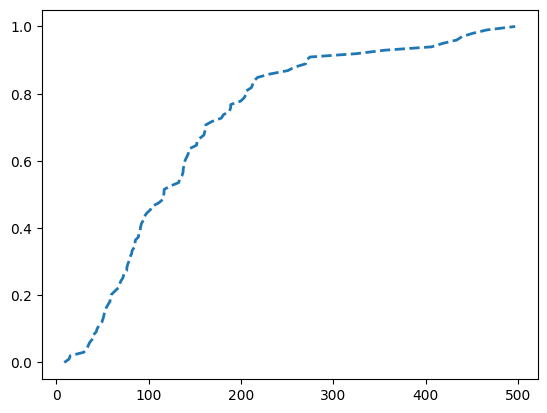

In [285]:
dist_phase = dist_from_geo(y_pred_phase, tx_test_phase)
cdf_plot(dist_phase)

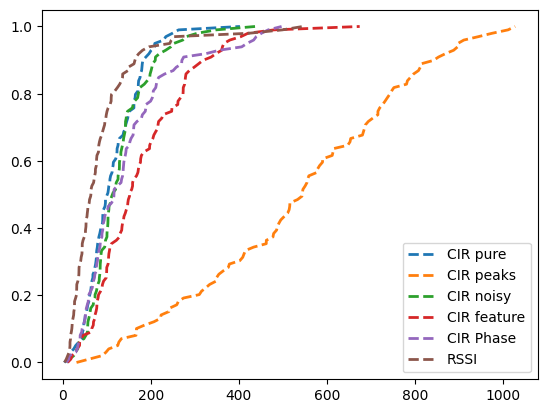

In [296]:
cdf_plot(error_pure)
cdf_plot(error_peak)
cdf_plot(error)
cdf_plot(error_feature)
cdf_plot(dist_phase)
cdf_plot(error_rssi)
plt.legend(['CIR pure', 'CIR peaks', 'CIR noisy', 'CIR feature', 'CIR Phase', 'RSSI'])
# plt.savefig('./imgs/general_comparison.pdf')